In [1]:
using LinearAlgebra, ApproxFun, Plots, LaTeXStrings

In [2]:
import Base: exp
import ApproxFun: bandwidth

function exp(L::Operator,B::Operator,t::Real,u0::Fun,n::Integer)
    S = space(u0)
    QS = QuotientSpace(B)
    Q = Conversion(QS,S)
    
    NS = NormalizedPolynomialSpace(S)
    D1 = Conversion(S,NS)
    D2 = Conversion(NS,S)
    
    L = -L # We'll negate this later
    R = D1*Q
    C = Conversion(domainspace(L), rangespace(L))
    P = cache(PartialInverseOperator(C,(0,bandwidth(L,1) + bandwidth(R,1) + bandwidth(C,2))))
    
    AA = R'D1*P*L*D2*R
    BB = R'R
    SB = Symmetric(BB[1:n,1:n],:L)
    SA = Symmetric(AA[1:n,1:n],:L) + 0*SB # + 0*SB is a bug workaround for bandwidths in A smaller than bandwidths in B.
    
    Λ,V = eigen(SA,SB);
    Λ = -Diagonal(Λ) # negation complete!
    
    w = Fun(x->Number((B*u0)[1]) + Number((B*u0)[2])*x,S,2) # A degree-1 polynomial that exactly captures nonzero boundary data
    v0 = pad(Q\(u0-w),n) # We'll represent u(x,t) = v(x,t) + w(x), where v satisfies 0 boundary data for all time
    u = Q*chop(Fun(QS,V*exp(t*Λ)*(V'*(SB*v0.coefficients))))
    
    return u
end

exp(L::Operator,B::Operator,t::Real,u0::Fun) = exp(L,B,t,u0,ncoefficients(u0))
exp(L::Operator,B::Operator,t::Real,u0::Fun,tol::Real) = exp(L,B,t,u0,ncoefficients(chop(u0,tol)))

exp (generic function with 35 methods)

In [3]:
X = Ultraspherical(0.5,0..1)
D = Derivative(X)
θ = (D=0.05,)
Δ = D^2
L = θ.D*Δ
B = [ldirichlet(X);rneumann(X)]
ϵ = 10^-1.5
u0 = Fun(x->(tanh((x-0.3)/ϵ)-tanh((x-0.7)/ϵ))/2,X)

Fun(Ultraspherical(0.5,0..1),[0.3999999998180962, -6.515012701744117e-17, -0.8301303965974424, 1.6342075460421925e-16, 0.6835236701739089, -1.5115939275916367e-16, -0.26358813580815477, 8.441135174893806e-18, -0.15067088772395607, 1.6404989183459173e-16  …  9.841189695267936e-17, -2.5451344165227694e-15, -2.4716464282970368e-17, 1.460296118188557e-15, -2.8242185072775684e-17, -1.973074211747124e-16, 5.5118081969246916e-17, -9.037214141941606e-16, -6.88118909792821e-17, 9.513061728764513e-16])

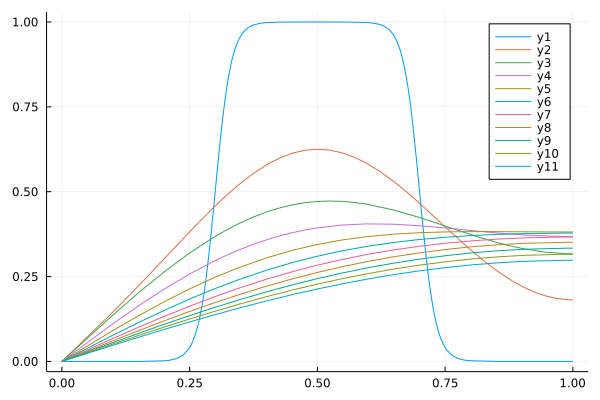

In [4]:
u = exp.(Ref(L),Ref(B),0:0.5:5,u0)
plot()
plot!(u)

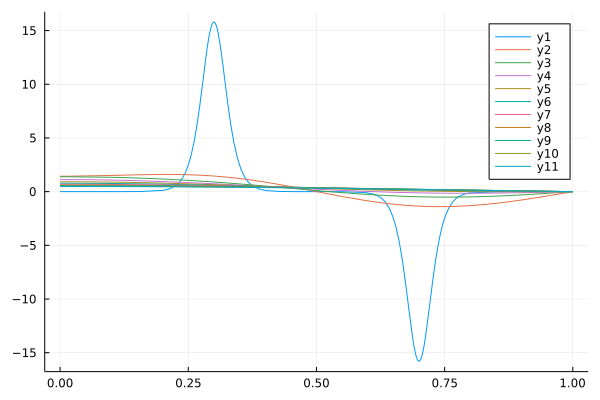

In [5]:
plot()
plot!(Ref(𝒟).*u)

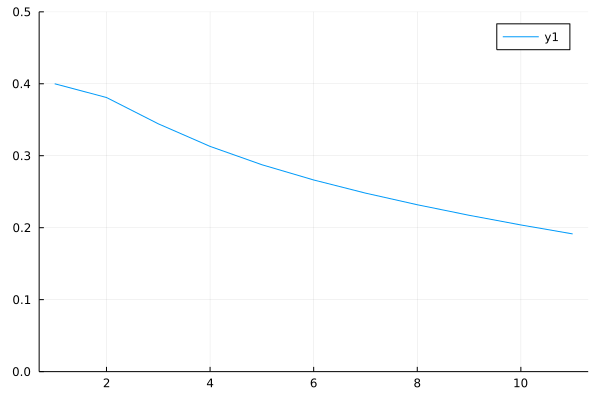

In [6]:
plot(sum.(u),ylims=(0,0.5))

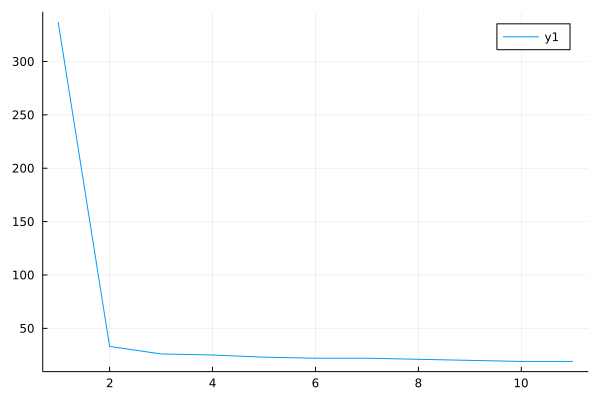

In [7]:
plot(ncoefficients.(u))